In [392]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import copy

In [393]:
class Tile:
    
    def __init__(self):
        self.ID = -1
        
        self.possibilities = set()
        
        self.entropy = len(self.possibilities)
        
        self.collapsed = False
    
    def set_possibilities(self, possibilities):
        if self.collapsed == False:
            current_possibilities = copy.copy(self.possibilities)
            for pos in current_possibilities:
                if pos not in possibilities:
                    self.possibilities.remove(pos)
    
    def collapse(self):
        self.ID = np.random.choice(list(self.possibilities))
        self.collapsed = True

In [394]:
x = Tile()
y = Tile()
x.possibilities.update([1,2,3,4,5,6])
y.possibilities.update([4,5,6,7])

y.set_possibilities(x.possibilities)
y.collapse()
y.ID

5

In [395]:
class Map():
    def __init__(self, image, tile_size):
        self.image = image
        self.tile_size = tile_size
        
        self.w = image.shape[0]
        self.h = image.shape[1]
        
        def get_tiles(image, w, h, tile_size):
            tiles = [
            image[x:x+tile_size,y:y+tile_size,:] 
            for x in range(0,w, tile_size) 
            for y in range(0,h,tile_size)
            ]
            return tiles
        
        self.tiles = get_tiles(self.image, self.w, self.h, self.tile_size)
        
        def get_hash_tiles(tiles):
            hashed_tiles = [pHash(tile) for tile in tiles]  
            return hashed_tiles
        
        def pHash(cv_image):
            imgg = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY);
            h=cv2.img_hash.pHash(imgg) # 8-byte hash
            pH=int.from_bytes(h.tobytes(), byteorder='big', signed=False)
            return pH
        
        self.hashed_tiles = get_hash_tiles(self.tiles)
        
        self.unique_hashes = list(dict.fromkeys(self.hashed_tiles))
        


        self.hash_int_dict = dict([(self.unique_hashes[i], i) for i in range(len(self.unique_hashes))])
        self.hash_tile_dict = dict(zip(self.hashed_tiles, self.tiles))
        self.int_tile_dict = dict([(self.hash_int_dict[i], self.hash_tile_dict[i]) for i in self.unique_hashes])
        
        self.int_tiles = [self.hash_int_dict[hash] for hash in self.hashed_tiles]
        
        self.unique_ints = list(dict.fromkeys(self.int_tiles))
        
        
        def get_corpus():
            matrix_tiles = np.array(self.int_tiles).reshape((self.w//self.tile_size, self.h//self.tile_size))
            
            sequence = {}

            for i in range((self.w//self.tile_size)-1):
                for j in range((self.h//self.tile_size-1)):
                    if matrix_tiles[i,j] not in sequence:
                        sequence[matrix_tiles[i,j]] = {
                            0 : {matrix_tiles[i, j - 1 % (self.h//self.tile_size)]},
                            1 : {matrix_tiles[i + 1 % (self.w//self.tile_size), j]},
                            2 : {matrix_tiles[i, j + 1 % (self.h//self.tile_size)]},
                            3 : {matrix_tiles[i - 1 % (self.w//self.tile_size), j]},
                        }
                    else:
                        sequence[matrix_tiles[i,j]][0].add(matrix_tiles[i, j - 1 % (self.h//self.tile_size)])
                        sequence[matrix_tiles[i,j]][1].add(matrix_tiles[i + 1 % (self.w//self.tile_size), j])
                        sequence[matrix_tiles[i,j]][2].add(matrix_tiles[i, j + 1 % (self.h//self.tile_size)])
                        sequence[matrix_tiles[i,j]][3].add(matrix_tiles[i - 1 % (self.w//self.tile_size), j])
            
            return sequence
        
        self.corpus = get_corpus()
        

libpng warning: iCCP: known incorrect sRGB profile


(2160, 2176)


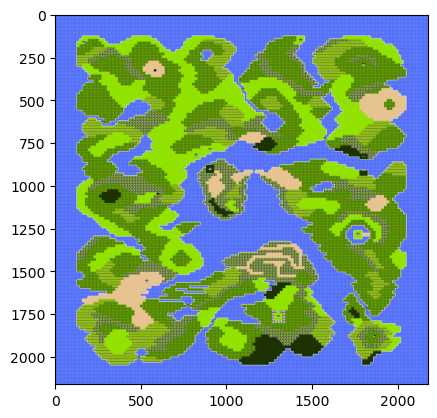

In [396]:
dq_level = cv2.imread("images/NES - Dragon Warrior - Overworld.png")
print(dq_level.shape[0:2])
plt.imshow(dq_level[:,:,::-1])
plt.show()

In [397]:
dq_map = Map(dq_level, 16)
print(dq_map.unique_ints)
print(dq_map.corpus[y.ID][0])

dq_map.corpus

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
{4, 6, 8, 10, 19, 26}


{0: {0: {0, 1, 2, 5, 7, 13, 15, 17},
  1: {0, 1, 2, 3, 5, 7, 11, 23, 25},
  2: {0, 1, 2, 3, 11, 15, 16, 18, 22},
  3: {0, 1, 7, 11, 13, 15, 16, 23, 25}},
 1: {0: {0, 1, 7}, 1: {0, 1}, 2: {0, 1}, 3: {0, 1}},
 2: {0: {0, 2, 5, 7, 13, 17, 22},
  1: {4, 6, 8, 10, 19, 20, 26},
  2: {0, 2, 3, 15, 16, 18, 22},
  3: {0, 7, 11, 13, 15, 16}},
 3: {0: {0, 2, 5, 7, 13, 15, 17, 22},
  1: {4, 6, 8, 10, 19, 26},
  2: {4, 6, 8, 10, 19, 26},
  3: {0, 7, 11, 13, 15, 16, 23}},
 4: {0: {3, 4, 6, 8, 9, 10, 11, 12, 16, 18, 23, 24, 25, 26, 27, 28},
  1: {4, 6, 8, 9, 10, 12, 13, 15, 16, 17, 18, 24, 26, 27, 28},
  2: {4, 5, 6, 7, 8, 9, 10, 12, 13, 17, 19, 20, 23, 25, 26, 27, 28},
  3: {2, 3, 4, 5, 6, 8, 9, 10, 12, 17, 18, 19, 21, 22, 26, 27, 28}},
 5: {0: {4, 6, 8, 10, 19, 26},
  1: {4, 6, 8, 10, 19},
  2: {0, 2, 3, 11, 15, 16, 18, 22},
  3: {0, 7, 11, 13, 15, 16, 23, 25}},
 6: {0: {3, 4, 6, 8, 9, 10, 11, 12, 14, 16, 18, 19, 21, 23, 25, 26, 28},
  1: {4, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 26}

In [398]:
class Grid:
    def __init__(self, width, height, img, t_size):
        self.width = width
        self.height = height
        self.t_size = t_size
        self.map_data = Map(img, t_size)
        self.grid = []
        
        
    def initialize(self):
        for i in range(self.width):
            self.grid.append([])
            for j in range(self.height):
                tile = Tile()
                tile.possibilities.update(self.map_data.unique_ints)
                self.grid[i].append(tile)
                
    def WaveFunctionCollapse(self):
        # i = np.random.randint(0, self.width)
        # j = np.random.randint(0, self.height)
        self.initialize()
        corpus = self.map_data.corpus
        
        for i in range(self.width):
            for j in range(self.height):
                print(i,j)   
                if self.grid[i][j].collapsed == False:
                    self.grid[i][j].collapse()
                    self.grid[(i - 1) % self.width][j].set_possibilities(corpus[self.grid[i][j].ID][0])
                    self.grid[i][(j + 1) % self.height].set_possibilities(corpus[self.grid[i][j].ID][1])
                    self.grid[(i + 1) % self.width][j].set_possibilities(corpus[self.grid[i][j].ID][2])
                    self.grid[i][(j - 1) % self.height].set_possibilities(corpus[self.grid[i][j].ID][3])
                
            #     print(self.grid[i][j].possibilities)
            # else:
            #     continue
            # step = np.random.randint(0, 4)
            # match step:
            #     case 0:
            #         i = (i - 1) % self.height
            #     case 1:
            #         j = (j + 1) % self.width
            #     case 2:
            #         i = (i + 1) % self.height
            #     case 3:
            #         j = (j - 1) % self.width
            # print(counter)
        
                

                        
    def get_grid_values(self):
        grid_ids = [[tile.ID for tile in i] for i in self.grid]
        
        return grid_ids
    def get_grid_possibilities(self):
        grid_pos = [[tile.possibilities for tile in i] for i in self.grid]
        
        return grid_pos

In [399]:
wfc = Grid(width=5, height=5, img=dq_level, t_size=16)

wfc.WaveFunctionCollapse()

print(wfc.get_grid_possibilities())

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4
[[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}, {4, 6, 8, 10, 12, 13, 15, 16, 17, 18, 19, 20, 22, 26}, {4, 6, 19}, {4, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 26}, {6, 8, 10, 12, 17, 18, 19, 20, 22}], [{5, 6, 7, 8, 10, 12, 13, 17, 19, 20, 25, 26}, {4, 6, 19}, {4, 6, 8, 9, 10, 12, 13, 17, 24, 26, 28}, {6, 8, 10, 12, 13, 17, 19, 26}, {4, 6, 8, 10, 19, 26}], [{4, 5, 6, 7, 8, 10, 13, 17, 19, 23, 26}, {4, 6, 8, 10, 13, 17, 19, 20, 26}, {4, 6, 8, 10, 13, 17, 19, 26}, {15}, {5}], [{4, 5, 6, 7, 8, 10, 13, 17, 19, 26}, {4, 6, 8, 10, 13, 26}, {4, 6, 8, 9, 10, 12, 13, 17, 19, 26}, {0, 3}, {2, 3}], [{4, 6, 8, 10, 19, 20, 26}, {4, 6, 19}, {16}, {3, 11}, {3}]]


In [404]:
print(wfc.get_grid_values())

[[22, 22, 6, 17, 10], [17, 19, 9, 17, 6], [6, 20, 10, 15, 5], [4, 13, 13, 3, 3], [4, 19, 16, 3, 3]]


In [405]:
map_tiles = copy.copy(wfc.get_grid_values())
for i in range(5):
    for j in range(5):
        map_tiles[i][j] = wfc.map_data.int_tile_dict[map_tiles[i][j]]

In [406]:
level_concat = []
for i in map_tiles:
    level_concat.append(cv2.hconcat(i))
    
final_level = cv2.vconcat(level_concat)

In [409]:
cv2.imshow("fixed", final_level)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [400]:
for i in range(5):
    for j in range(5):
        print("tile ", i,j)
        print("main: ", wfc.grid[i][j].possibilities)
        wfc.grid[i][j].collapse()
        print(wfc.grid[i][j].ID)
        wfc.grid[i][(j + 1) % 5].set_possibilities(dq_map.corpus[wfc.grid[i][j].ID][1])
        print("right: ", wfc.grid[i][(j + 1) % 5].possibilities)

tile  0 0
main:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}
22
right:  {4, 6, 8, 10, 12, 13, 15, 16, 17, 18, 19, 20, 22, 26}
tile  0 1
main:  {4, 6, 8, 10, 12, 13, 15, 16, 17, 18, 19, 20, 22, 26}
22
right:  {4, 6, 19}
tile  0 2
main:  {4, 6, 19}
6
right:  {4, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 26}
tile  0 3
main:  {4, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 26}
17
right:  {6, 8, 10, 12, 17, 18, 19, 20, 22}
tile  0 4
main:  {6, 8, 10, 12, 17, 18, 19, 20, 22}
10
right:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}
tile  1 0
main:  {5, 6, 7, 8, 10, 12, 13, 17, 19, 20, 25, 26}
17
right:  {4, 6, 19}
tile  1 1
main:  {4, 6, 19}
19
right:  {4, 6, 8, 9, 10, 12, 13, 17, 24, 26, 28}
tile  1 2
main:  {4, 6, 8, 9, 10, 12, 13, 17, 24, 26, 28}
9
right:  {6, 8, 10, 12, 13, 17, 19, 26}
tile  1 3
main:  {6, 8, 10, 12, 13, 17, 19, 26}
17
right:  {4,

In [401]:
i,j = 4, 0
step = np.random.randint(0, 4)
match step:
    case 0:
        i = (i - 1) % wfc.height
    case 1:
        j = (j + 1) % wfc.width
    case 2:
        i = (i + 1) % wfc.height
    case 3:
        j = (j - 1) % wfc.width
        
print(i,j)

4 1


In [402]:
def pHash(cv_image):
    imgg = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY);
    h=cv2.img_hash.pHash(imgg) # 8-byte hash
    pH=int.from_bytes(h.tobytes(), byteorder='big', signed=False)
    return pH

In [403]:
width, height, _ = dq_map.shape

M = 16
N = 16


tiles = [dq_map[x:x+M,y:y+N,:] for x in range(0,width,M) for y in range(0,height,N)]
print(len(tiles))
print(width/16)


AttributeError: 'Map' object has no attribute 'shape'

In [ ]:
-1 % 16

15

In [ ]:
matrix_tiles = np.array(int_tiles).reshape((width//16, height//16))

matrix_tiles[0,-1 % height//16]

0

In [ ]:
height

2176

In [ ]:
sequence = {}

for j in range(height//16-1):
    for i in range(width//16-1):
        if matrix_tiles[i,j] not in sequence:
            sequence[matrix_tiles[i,j]] = {
                0 : {matrix_tiles[i, j - 1 % (height//16)]},
                1 : {matrix_tiles[i + 1 % (width//16), j]},
                2 : {matrix_tiles[i, j + 1 % (height//16)]},
                3 : {matrix_tiles[i - 1 % (width//16), j]},
            }
        else:
            sequence[matrix_tiles[i,j]][0].add(matrix_tiles[i, j - 1 % (height//16)])
            sequence[matrix_tiles[i,j]][1].add(matrix_tiles[i + 1 % (width//16), j])
            sequence[matrix_tiles[i,j]][2].add(matrix_tiles[i, j + 1 % (height//16)])
            sequence[matrix_tiles[i,j]][3].add(matrix_tiles[i - 1 % (width//16), j])

In [ ]:
sequence

{0: {0: {0, 1, 2, 5, 7, 13, 15, 17},
  1: {0, 1, 2, 3, 5, 7, 11, 23, 25},
  2: {0, 1, 2, 3, 11, 15, 16, 18, 22},
  3: {0, 1, 7, 11, 13, 15, 16, 23, 25}},
 11: {0: {0, 5, 7, 13, 15},
  1: {0, 2, 3, 5, 11},
  2: {4, 6, 8, 10, 19, 26},
  3: {0, 11, 15, 16, 23, 24}},
 3: {0: {0, 2, 5, 7, 13, 15, 17, 22},
  1: {4, 6, 8, 10, 19, 26},
  2: {4, 6, 8, 10, 19, 26},
  3: {0, 7, 11, 13, 15, 16, 23}},
 4: {0: {3, 4, 6, 8, 9, 10, 11, 12, 16, 18, 23, 24, 25, 26, 27, 28},
  1: {4, 6, 8, 9, 10, 12, 13, 15, 16, 17, 18, 24, 26, 27, 28},
  2: {4, 5, 6, 7, 8, 9, 10, 12, 13, 17, 19, 20, 23, 25, 26, 27, 28},
  3: {2, 3, 4, 5, 6, 8, 9, 10, 12, 17, 18, 19, 21, 22, 26, 27, 28}},
 6: {0: {3, 4, 6, 8, 9, 10, 11, 12, 14, 16, 18, 19, 21, 23, 25, 26, 28},
  1: {4, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 26},
  2: {4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 17, 19, 21, 23, 24, 25, 26, 28},
  3: {2, 3, 4, 5, 6, 8, 9, 10, 12, 17, 18, 19, 22, 26, 28}},
 8: {0: {3, 4, 6, 8, 10, 11, 16, 18, 19, 23, 26},
  1: {4, 6, 8,

In [ ]:
1 - 1 % (height//16)

0

In [ ]:
height//16

136

In [ ]:
tr = {}
test = [1,1,1,4,4,2,2,3,3]
for x in test:
    if x not in tr:
        tr[x] = 1
    else:
        tr[x] +=1
        
tr

{1: 3, 4: 2, 2: 2, 3: 2}

In [ ]:
def pHash(cv_image):
        imgg = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY);
        h=cv2.img_hash.pHash(imgg) # 8-byte hash
        pH=int.from_bytes(h.tobytes(), byteorder='big', signed=False)
        return pH

hashed_tiles = [pHash(tile) for tile in tiles]
int_tiles = [hash_int_dict[hash] for hash in hashed_tiles]

unique_hashes = list(dict.fromkeys(hashed_tiles))


hash_int_dict = dict([(unique_hashes[i], i) for i in range(len(unique_hashes))])
hash_tile_dict = dict(zip(hashed_tiles, tiles))
int_tile_dict = dict([(hash_int_dict[i], hash_tile_dict[i]) for i in unique_hashes])


print(int_tile_dict.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])


In [ ]:
x = Tile()
y = copy.copy(x)

In [ ]:
type(x)

__main__.Tile

In [ ]:
x.ID = 3

print(y.ID)

-1


In [ ]:
grid = []
for i in range(10):
    grid.append(Tile())

In [ ]:
for tile in grid:
    tile.possibilities = list(int_tile_dict.keys())


In [ ]:
for tile in grid:
    tile.collapse()
    print(tile.ID)

3
4
26
5
16
28
18
17
6
5


In [ ]:
grid_values = [tile.ID for tile in grid]
print(grid_values)

[3, 4, 26, 5, 16, 28, 18, 17, 6, 5]


In [ ]:
tile_values =[int_tile_dict[i] for i in grid_values] 